In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
import PIL
import read_datasets as rd
import constants as CONST
from importlib import reload
reload(rd)
reload(CONST)
import base64
import pickle
import collections
import itertools, collections
from sklearn.metrics import mean_squared_error
import cv2 

In [2]:
import torch

In [3]:
np.set_printoptions(precision=4, suppress=True)

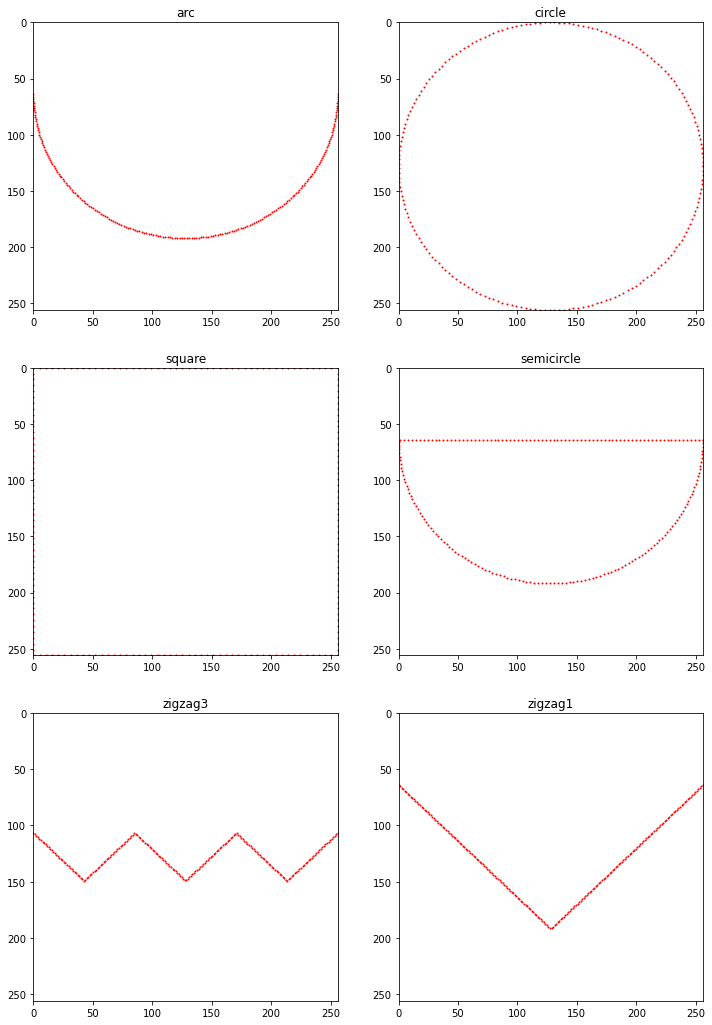

In [4]:
rd.plot_primitives(row_figsize = 6, column_figsize = 6)

In [5]:
drawing_arr = CONST.face_json['train_data']
n = 200
h,w = 256,256

In [6]:
# reload(rd)
# prim = rd.generate_zigzag3()
# # prim = rd.interpcurve(200, prim[:,0], prim[:,1])
# # np.sqrt(np.sum((prim[1:]-prim[:-1])**2,axis=1)) 

# plt.figure(figsize=(12,12))
# plt.scatter(prim[:,0], prim[:,1], s=1, c='r')
# h,w = 256,256
# plt.xlim(0,w)
# plt.ylim(h,0)
# plt.show()

In [61]:
from tqdm import tqdm

use_projective = True

drawing_arr = CONST.face_json['train_data']

M_arr = collections.defaultdict(lambda : np.zeros(9))
M_name = collections.defaultdict(lambda : " ")
M_mse = collections.defaultdict(float)

b_spline_num_sampled_points = n

for idx in tqdm(range(len(drawing_arr))):
    strokes_spline_fitted = rd.process_quickdraw_to_stroke_no_normalize(
        drawing_arr[idx], 
        b_spline_num_sampled_points=200,
    )
    
    for stroke_index, data in enumerate(strokes_spline_fitted):
        min_template_name, min_template_mse = None, np.inf
        min_M = None
        for template_name, template_func in rd.TEMPLATE_DICT.items():
            template = template_func(n)
            try:
                M, result = rd.get_transform(template, data, projective=use_projective)
            except:
                try:
                    mask = np.zeros(len(data))
                    mask[:20] = 1
                    np.random.shuffle(mask)
                    data = data + (np.random.normal(0, 0.05, len(data)) * mask).reshape(-1,1)
                    M, result = rd.get_transform(template, data, projective=use_projective)
                except:
                    continue
            mse = rd.mean_squared_error(result, data)
            if mse < min_template_mse:
                min_template_name = template_name
                min_template_mse = mse
                min_M = M
        
        if min_M is None:
            M_arr[(idx, stroke_index)] = np.zeros(9)
            M_name[(idx, stroke_index)] = 'line'
            M_mse[(idx, stroke_index)] = min_template_mse
        else:
            M_arr[(idx, stroke_index)] = min_M.reshape(-1,)
            M_name[(idx, stroke_index)] = min_template_name
            M_mse[(idx, stroke_index)] = min_template_mse

        
with open('/raid/xiaoyuz1/SPG_Face_256_projective_mse.pkl', "wb+") as f:
    pickle.dump((dict(M_arr), dict(M_name), dict(M_mse)), f)

100%|██████████| 800/800 [01:24<00:00,  9.43it/s]


In [62]:
line_dict = dict(filter(lambda x: x[1] == 'line', M_name.items()))
print(len(line_dict), line_dict)

0 {}


In [63]:
M_arr, M_name = None,None
M_mse = None
with open('/raid/xiaoyuz1/SPG_Face_256_projective_mse.pkl', "rb") as f:
    M_arr, M_name, M_mse = pickle.load(f)

In [64]:
import math

In [65]:
mse_l = list(filter(lambda x: not math.isinf(x), list(M_mse.values())))
np.mean(mse_l)

29.198029288050922

In [66]:
image_list = list(map(lambda x: x[0], M_name.keys()))
stroke_list = list(map(lambda x: x[1], M_name.keys()))
arr_list = list(M_arr.values())
name_list = list(M_name.values())
mse_list = list(M_mse.values())

data = {'image': image_list, 'stroke' : stroke_list, 'M' : arr_list, 'primitive' : name_list, 'mse' : mse_list}
df = pd.DataFrame.from_dict(data)

In [67]:
dfa = df[df.mse.apply(lambda x: not math.isinf(x))]

In [68]:
print(len(dfa))

4799


In [69]:
dfa.primitive.unique()

array(['circle', 'arc', 'zigzag1', 'square', 'semicircle', 'zigzag3'],
      dtype=object)

In [78]:
dfa[dfa['mse'] >= 10]

,image,stroke,M,primitive,mse
0,0,0,"[-0.45756674413275644, -0.6650365591261901, 27...",circle,30.315444
1,0,1,"[0.34003511941727804, -0.16647467813936273, 10...",circle,16.541064
2,0,2,"[0.28550124690610057, -0.05812930820612069, 20...",circle,57.927720
4,1,0,"[0.07426618644942073, -0.7638244586723916, 209...",circle,158.619724
7,1,3,"[0.19429706094749774, -0.30443076333717334, 13...",square,68.302203
...,...,...,...,...,...
4786,798,8,"[0.14625424143103427, 0.6449338460600859, 78.5...",arc,65.385676
4787,798,9,"[0.12858086223918394, -0.21458547292413488, 11...",semicircle,18.705722
4793,799,0,"[0.17507131867447648, -0.4479608535644788, 124...",circle,25.281218
4797,799,4,"[0.15225883166167298, -0.03110723947371908, 17...",zigzag1,131.915748


In [99]:
idx = 83
stroke_idx = 1

In [100]:
drawing_raw = np.asarray(drawing_arr[idx])
drawing_raw[:,0] = np.cumsum(drawing_raw[:,0], 0) + 25
drawing_raw[:,1] = np.cumsum(drawing_raw[:,1], 0) + 25
pen_lift_indices = np.where(drawing_raw[:,2] == 1)[0]+1
strokes = np.vsplit(drawing_raw[:,:2].astype(float), pen_lift_indices)[:-1]

In [101]:
reload(rd)

<module 'read_datasets' from '/home/xiaoyuz1/amazon_turk/read_datasets.py'>

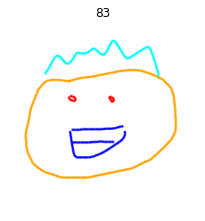

7


In [102]:
# print(dict(filter(lambda x: x[0][0] == idx, M_name.items())))

rd.show_these_sketches(
    CONST.face_json,
    [idx], 
    [str(idx)], 
    [[]], 
    num_pngs_per_row = 6,
    row_figsize = 4,
    column_figsize = 4,
)

strokes_spline_fitted = rd.process_quickdraw_to_stroke_no_normalize(
    drawing_arr[idx], 
    b_spline_num_sampled_points=200,
)
print(len(strokes_spline_fitted))

In [103]:
data = strokes_spline_fitted[stroke_idx]

In [104]:
dfa[dfa.image == idx]

,image,stroke,M,primitive,mse
472,83,0,"[-0.3314636167521527, -0.6857078361290114, 250...",circle,66.153807
473,83,1,"[-0.07155207320892447, -0.01581141699761102, 9...",circle,0.073649
474,83,2,"[-0.007916815629508371, 0.0028602640167163466,...",circle,0.048681
475,83,3,"[0.2673029889082262, -0.0019313827267778312, 8...",zigzag1,0.068493
476,83,4,"[-0.4201612621486127, -0.10237477109468826, 16...",arc,1.111568
477,83,5,"[-0.9448814539148185, -0.46968645591996677, 15...",arc,0.566527
478,83,6,"[-0.7787710665872494, 1.7803221205610993, 199....",arc,34.962272


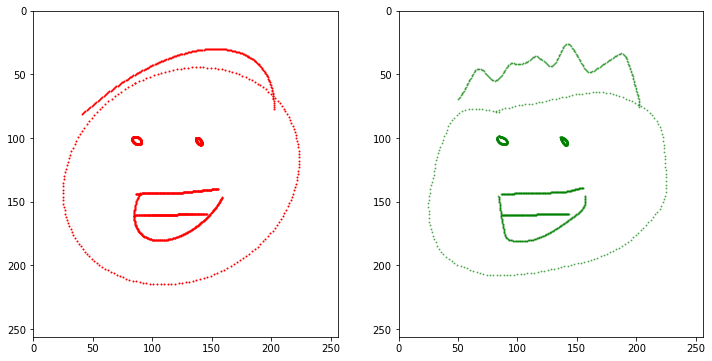

In [105]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

for index, entry in dfa[dfa.image == idx].iterrows():
    data = strokes_spline_fitted[entry.stroke]
    template_func = rd.TEMPLATE_DICT[entry.primitive]
    template = template_func(n)
    
    result, mse = rd.get_transformed_template(template, data, entry.M.reshape(3,3))
    ax1.scatter(result[:,0], result[:,1], label="transformed template", s=1, c='r')
    ax2.scatter(data[:,0], data[:,1], label="data", alpha=0.5, s=1, c='g')

# plt.legend()
# plt.xlim(0,w)
# plt.ylim(h,0)

ax1.axis(xmin=0,xmax=w)
ax1.axis(ymin=h,ymax=0)

ax2.axis(xmin=0,xmax=w)
ax2.axis(ymin=h,ymax=0)

plt.show()

2.9199214787598444e-06


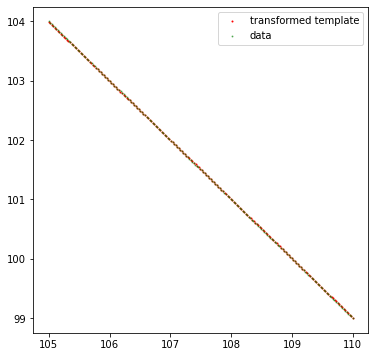

In [76]:
data = strokes_spline_fitted[stroke_idx]
template_func = rd.TEMPLATE_DICT[M_name[(idx, stroke_idx)]]
template = template_func(n)

result, mse = rd.get_transformed_template(template, data, M_arr[(idx, stroke_idx)].reshape(3,3))

print(mse)

datacolors = rd.get_sequence_colors(n, plt.cm.Greens)
templatecolors = rd.get_sequence_colors(n, plt.cm.Reds)

plt.figure(figsize=(6, 6))
# plt.scatter(result[:,0], result[:,1], label="transformed template", s=1, \
#             c=templatecolors)
# plt.scatter(data[:,0], data[:,1], label="data", alpha=0.5, s=1, c=datacolors)

plt.scatter(result[:,0], result[:,1], label="transformed template", s=1, c='r')
plt.scatter(data[:,0], data[:,1], label="data", alpha=0.5, s=1, c='g')

plt.legend()
# plt.xlim(0,w)
# plt.ylim(h,0)

plt.show()

In [ ]:
maxs = np.max(stroke, axis=0)
    mins = np.min(stroke, axis=0)
    ll = maxs - mins

    if np.any(np.isclose(ll, 1e-8, rtol=1, atol=1e-07)):
        stroke_sampled = square_from_line(stroke)
    else:
        #stroke_sampled = bspline(stroke, n=b_spline_num_sampled_points, degree=b_spline_degree)
        stroke_sampled = interpcurve(b_spline_num_sampled_points, stroke[:,0], stroke[:,1])

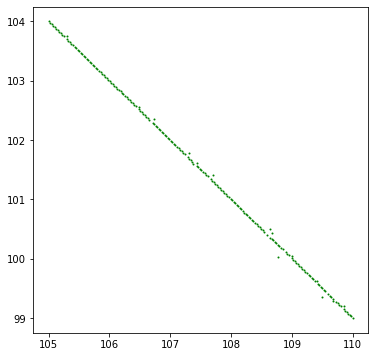

In [48]:
plt.figure(figsize=(6,6))
stroke_i = strokes_spline_fitted[stroke_idx]
# mask = np.zeros(len(data))
# mask[:20] = 1
# np.random.shuffle(mask)
# stroke_i = data + (np.random.normal(0, 0.05, len(data)) * mask).reshape(-1,1)
plt.scatter(stroke_i[:,0], stroke_i[:,1], label="template", s=1, c='g')
# plt.xlim(0,w)
# plt.ylim(h,0)
plt.show()

In [14]:
reload(rd)

<module 'read_datasets' from '/home/xiaoyuz1/amazon_turk/read_datasets.py'>

In [49]:
data = strokes_spline_fitted[stroke_idx]

In [23]:

print(M_name[(idx, stroke_idx)])

template_func = rd.TEMPLATE_DICT[M_name[(idx, stroke_idx)]]

circle


In [24]:
projectiveM = M_arr[(idx, stroke_idx)]
template = template_func(n)
src_pts = template.astype(np.float32).reshape(-1,1,2)
result = cv2.perspectiveTransform(src_pts, projectiveM.reshape(3,3)).reshape(-1,2)

In [58]:
# calculate ourselves
template_func = rd.TEMPLATE_DICT['zigzag1']
template = template_func(n)

# template = rd.generate_zigzag(num_fold=10)
M, result = rd.get_transform(template, data, projective=True)

In [59]:
data.shape, template.shape

((200, 2), (200, 2))

0.00017625007577857225


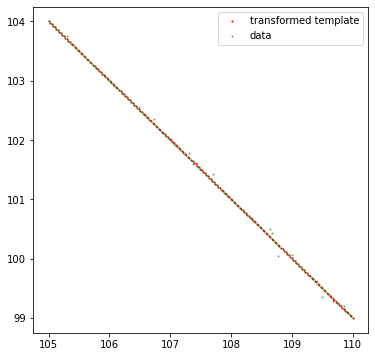

In [60]:
mse = mean_squared_error(result, data)
print(mse)

datacolors = rd.get_sequence_colors(n, plt.cm.Greens)
templatecolors = rd.get_sequence_colors(n, plt.cm.Reds)

plt.figure(figsize=(6, 6))
# plt.scatter(result[:,0], result[:,1], label="transformed template", s=1, \
#             c=templatecolors)
# plt.scatter(data[:,0], data[:,1], label="data", alpha=0.5, s=1, c=datacolors)

plt.scatter(result[:,0], result[:,1], label="transformed template", s=1, c='r')
plt.scatter(data[:,0], data[:,1], label="data", alpha=0.5, s=1, c='g')

plt.legend()
# plt.xlim(0,w)
# plt.ylim(h,0)

plt.show()

In [ ]:
import cv2
import numpy as np
import sys
from numpy.random import *

In [ ]:
def del_miss(indeces, dist, max_dist, th_rate = 0.8):
    th_dist = max_dist * th_rate
    return np.array([indeces[0][np.where(dist.T[0] < th_dist)]])


In [ ]:
def is_converge(Tr, scale):
    delta_angle = 0.0001
    delta_scale = scale * 0.0001
    
    min_cos = 1 - delta_angle
    max_cos = 1 + delta_angle
    min_sin = -delta_angle
    max_sin = delta_angle
    min_move = -delta_scale
    max_move = delta_scale
    
    return min_cos < Tr[0, 0] and Tr[0, 0] < max_cos and \
           min_cos < Tr[1, 1] and Tr[1, 1] < max_cos and \
           min_sin < -Tr[1, 0] and -Tr[1, 0] < max_sin and \
           min_sin < Tr[0, 1] and Tr[0, 1] < max_sin and \
           min_move < Tr[0, 2] and Tr[0, 2] < max_move and \
           min_move < Tr[1, 2] and Tr[1, 2] < max_move

In [ ]:
def icp(d1, d2, max_iterate = 100):
    src = np.array([d1.T], copy=True).astype(np.float32)
    dst = np.array([d2.T], copy=True).astype(np.float32)
    
    knn = cv2.KNearest()
    responses = np.array(range(len(d2[0]))).astype(np.float32)
    knn.train(src[0], responses)
        
    Tr = np.array([[np.cos(0), -np.sin(0), 0],
                   [np.sin(0), np.cos(0),  0],
                   [0,         0,          1]])

    dst = cv2.transform(dst, Tr[0:2])
    max_dist = sys.maxint
    
    scale_x = np.max(d1[0]) - np.min(d1[0])
    scale_y = np.max(d1[1]) - np.min(d1[1])
    scale = max(scale_x, scale_y)
       
    for i in range(max_iterate):
        ret, results, neighbours, dist = knn.find_nearest(dst[0], 1)
        
        indeces = results.astype(np.int32).T     
        indeces = del_miss(indeces, dist, max_dist)  
        
        T = cv2.estimateRigidTransform(dst[0, indeces], src[0, indeces], True)

        max_dist = np.max(dist)
        dst = cv2.transform(dst, T)
        Tr = np.dot(np.vstack((T,[0,0,1])), Tr)
        
        if (is_converge(T, scale)):
            break
        
    return Tr[0:2]

In [ ]:
if __name__ == "__main__":
    import matplotlib.pyplot as plt
    
    point_count = 100
    th = np.pi / 8
    move = np.array([[0.30], [0.5]])
    rnd_scale = 0.03
    x1 = np.linspace(0, 1.1, point_count)
    y1 = np.sin(x1 * np.pi)
    d1 = np.array([x1, y1])

    rot = np.array([[np.cos(th), -np.sin(th)], [np.sin(th), np.cos(th)]])
    rand = np.random.rand(2, point_count)*rnd_scale
    d2 = np.dot(rot, d1) + move
    d2 = np.add(d2, rand)

    plt.plot(d1[0], d1[1])
    plt.plot(d2[0], d2[1])
    plt.show()

In [ ]:
    ret = icp(d1, d2)
    
    plt.plot(d1[0], d1[1])
    dst = np.array([d2.T], copy=True).astype(np.float32)
    dst = cv2.transform(dst, ret)
    plt.plot(dst[0].T[0], dst[0].T[1])
    plt.show()
    
    print ret[0][0] * ret[0][0] + ret[0][1] * ret[0][1]
    print np.arccos(ret[0][0]) / 2 / np.pi * 360
    print np.arcsin(ret[0][1]) / 2 / np.pi * 360

    print ret

In [ ]:
def icp(a, b,
        max_time = 1
    ):
    import cv2
    import numpy
    import copy
    import pylab
    import time
    import sys
    import sklearn.neighbors
    import scipy.optimize



    def res(p,src,dst):
        T = numpy.matrix([[numpy.cos(p[2]),-numpy.sin(p[2]),p[0]],
        [numpy.sin(p[2]), numpy.cos(p[2]),p[1]],
        [0 ,0 ,1 ]])
        n = numpy.size(src,0)
        xt = numpy.ones([n,3])
        xt[:,:-1] = src
        xt = (xt*T.T).A
        d = numpy.zeros(numpy.shape(src))
        d[:,0] = xt[:,0]-dst[:,0]
        d[:,1] = xt[:,1]-dst[:,1]
        r = numpy.sum(numpy.square(d[:,0])+numpy.square(d[:,1]))
        return r

    def jac(p,src,dst):
        T = numpy.matrix([[numpy.cos(p[2]),-numpy.sin(p[2]),p[0]],
        [numpy.sin(p[2]), numpy.cos(p[2]),p[1]],
        [0 ,0 ,1 ]])
        n = numpy.size(src,0)
        xt = numpy.ones([n,3])
        xt[:,:-1] = src
        xt = (xt*T.T).A
        d = numpy.zeros(numpy.shape(src))
        d[:,0] = xt[:,0]-dst[:,0]
        d[:,1] = xt[:,1]-dst[:,1]
        dUdth_R = numpy.matrix([[-numpy.sin(p[2]),-numpy.cos(p[2])],
                            [ numpy.cos(p[2]),-numpy.sin(p[2])]])
        dUdth = (src*dUdth_R.T).A
        g = numpy.array([  numpy.sum(2*d[:,0]),
                        numpy.sum(2*d[:,1]),
                        numpy.sum(2*(d[:,0]*dUdth[:,0]+d[:,1]*dUdth[:,1])) ])
        return g
    
    def hess(p,src,dst):
        n = numpy.size(src,0)
        T = numpy.matrix([[numpy.cos(p[2]),-numpy.sin(p[2]),p[0]],
        [numpy.sin(p[2]), numpy.cos(p[2]),p[1]],
        [0 ,0 ,1 ]])
        n = numpy.size(src,0)
        xt = numpy.ones([n,3])
        xt[:,:-1] = src
        xt = (xt*T.T).A
        d = numpy.zeros(numpy.shape(src))
        d[:,0] = xt[:,0]-dst[:,0]
        d[:,1] = xt[:,1]-dst[:,1]
        dUdth_R = numpy.matrix([[-numpy.sin(p[2]),-numpy.cos(p[2])],[numpy.cos(p[2]),-numpy.sin(p[2])]])
        dUdth = (src*dUdth_R.T).A
        H = numpy.zeros([3,3])
        H[0,0] = n*2
        H[0,2] = numpy.sum(2*dUdth[:,0])
        H[1,1] = n*2
        H[1,2] = numpy.sum(2*dUdth[:,1])
        H[2,0] = H[0,2]
        H[2,1] = H[1,2]
        d2Ud2th_R = numpy.matrix([[-numpy.cos(p[2]), numpy.sin(p[2])],[-numpy.sin(p[2]),-numpy.cos(p[2])]])
        d2Ud2th = (src*d2Ud2th_R.T).A
        H[2,2] = numpy.sum(2*(numpy.square(dUdth[:,0])+numpy.square(dUdth[:,1]) + d[:,0]*d2Ud2th[:,0]+d[:,0]*d2Ud2th[:,0]))
        return H
    
    
    t0 = time.time()
    init_pose = (0,0,0)
    src = numpy.array([a.T], copy=True).astype(numpy.float32)
    dst = numpy.array([b.T], copy=True).astype(numpy.float32)
    Tr = numpy.array([[numpy.cos(init_pose[2]),-numpy.sin(init_pose[2]),init_pose[0]],
                   [numpy.sin(init_pose[2]), numpy.cos(init_pose[2]),init_pose[1]],
                   [0,                    0,                   1          ]])
    print("src",numpy.shape(src))
    print("Tr[0:2]",numpy.shape(Tr[0:2]))
    src = cv2.transform(src, Tr[0:2])
    p_opt = numpy.array(init_pose)
    T_opt = numpy.array([])
    error_max = sys.maxsize
    first = False
    while not(first and time.time() - t0 > max_time):
        distances, indices = sklearn.neighbors.NearestNeighbors(n_neighbors=1, algorithm='auto',p = 3).fit(dst[0]).kneighbors(src[0])
        p = scipy.optimize.minimize(res,[0,0,0],args=(src[0],dst[0, indices.T][0]),method='Newton-CG',jac=jac,hess=hess).x
        T  = numpy.array([[numpy.cos(p[2]),-numpy.sin(p[2]),p[0]],[numpy.sin(p[2]), numpy.cos(p[2]),p[1]]])
        p_opt[:2]  = (p_opt[:2]*numpy.matrix(T[:2,:2]).T).A       
        p_opt[0] += p[0]
        p_opt[1] += p[1]
        p_opt[2] += p[2]
        src = cv2.transform(src, T)
        Tr = (numpy.matrix(numpy.vstack((T,[0,0,1])))*numpy.matrix(Tr)).A
        error = res([0,0,0],src[0],dst[0, indices.T][0])

        if error < error_max:
            error_max = error
            first = True
            T_opt = Tr

    p_opt[2] = p_opt[2] % (2*numpy.pi)
    return T_opt, error_max


def main():
    import cv2
    import numpy
    import random
    import matplotlib.pyplot
    n1 = 100
    n2 = 75
    bruit = 1/10
    center = [random.random()*(2-1)*3,random.random()*(2-1)*3]
    radius = random.random()
    deformation = 2

    template = numpy.array([
        [numpy.cos(i*2*numpy.pi/n1)*radius*deformation for i in range(n1)], 
        [numpy.sin(i*2*numpy.pi/n1)*radius for i in range(n1)]
    ])

    data = numpy.array([
        [numpy.cos(i*2*numpy.pi/n2)*radius*(1+random.random()*bruit)+center[0] for i in range(n2)], 
        [numpy.sin(i*2*numpy.pi/n2)*radius*deformation*(1+random.random()*bruit)+center[1] for i in range(n2)]
    ])

    T,error = icp(data,template)
    dx = T[0,2]
    dy = T[1,2]
    rotation = numpy.arcsin(T[0,1]) * 360 / 2 / numpy.pi

    print("T",T)
    print("error",error)
    print("rotation°",rotation)
    print("dx",dx)
    print("dy",dy)

    result = cv2.transform(numpy.array([data.T], copy=True).astype(numpy.float32), T).T
    matplotlib.pyplot.plot(template[0], template[1], label="template")
    matplotlib.pyplot.plot(data[0], data[1], label="data")
    matplotlib.pyplot.plot(result[0], result[1], label="result: "+str(rotation)+"° - "+str([dx,dy]))
    matplotlib.pyplot.legend(loc="upper left")
    matplotlib.pyplot.axis('square')
    matplotlib.pyplot.show()

if __name__ == "__main__":
    main()